In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession
         .builder
         .appName("Yellow Taxi Data Analysis")
         .getOrCreate())
from functools import reduce
from pyspark.sql import DataFrame, Window
from pyspark.sql.functions import avg, sum, max, min, col, mean, stddev, count, format_number, dense_rank, round
from pyspark.sql.functions import month, day, hour, to_timestamp, date_format
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


### Creating DataFrame containing taxi data for each month in the year 2023.

In [2]:
dataset_paths = ['datasets/new_york_taxi/yellow_tripdata_2023-01.parquet',
                'datasets/new_york_taxi/yellow_tripdata_2023-02.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-03.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-04.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-05.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-06.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-07.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-08.parquet',
                 'datasets/new_york_taxi/yellow_tripdata_2023-09.parquet',
                'datasets/new_york_taxi/yellow_tripdata_2023-10.parquet']
taxi_data = []
for path in dataset_paths:
    taxi_data.append(spark.read.parquet(path))


### Merging DataFrames containing taxi data of each month in the year 2023.

In [3]:
taxi_data_complete = reduce(DataFrame.unionAll, taxi_data)
taxi_data_complete.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2023-01-01 00:32:10|  2023-01-01 00:40:36|            1.0|         0.97|       1.0|                 N|         161|         141|           2|        9.3|  1.0|    0.5|       0.

### Schema of the data

In [4]:
taxi_data_complete.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



### Preparing the data for analysis

#### Cleaning the data by dropping the null values and some of the rows


In [5]:
taxi_data_complete.dropna()
clean_taxi_data = taxi_data_complete.drop("store_and_fwd_flag","extra","mta_tax","tolls_amount","improvement_surcharge")


#### Showing the top row of the data

In [6]:
clean_taxi_data.head()

Row(VendorID=2, tpep_pickup_datetime=datetime.datetime(2023, 1, 1, 0, 32, 10), tpep_dropoff_datetime=datetime.datetime(2023, 1, 1, 0, 40, 36), passenger_count=1.0, trip_distance=0.97, RatecodeID=1.0, PULocationID=161, DOLocationID=141, payment_type=2, fare_amount=9.3, tip_amount=0.0, total_amount=14.3, congestion_surcharge=2.5, airport_fee=0.0)

#### Create new columns of 'month', 'week', 'day' & 'hour' from the date-time data

In [7]:
clean_taxi_data = clean_taxi_data.withColumn("pickup_month", month("tpep_pickup_datetime"))\
                                 .withColumn("dropoff_month", month("tpep_dropoff_datetime"))\
                                 .withColumn("pickup_day", day("tpep_pickup_datetime"))\
                                 .withColumn("dropoff_day", day("tpep_dropoff_datetime"))\
                                 .withColumn("pickup_hour", hour("tpep_pickup_datetime"))\
                                 .withColumn("dropoff_hour", hour("tpep_dropoff_datetime"))
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

clean_taxi_data = clean_taxi_data.withColumn("tpep_pickup_datetime",to_timestamp(col("tpep_pickup_datetime")))\
                                 .withColumn("week_day_full", date_format(col("tpep_pickup_datetime"), "EEEE"))\
                                 .withColumn("week_of_month", date_format(col("tpep_pickup_datetime"), "W"))

### Analysing the clean taxi data

#### 1) Calculating total Revenue and trips for the year

##### Total revenue for the year


In [8]:
total_revenue = clean_taxi_data.agg(sum("total_amount").alias("total_revenue"))
total_revenue = total_revenue.select(format_number("total_revenue", 0).alias("total_revenue($)"))
total_revenue.show()


+----------------+
|total_revenue($)|
+----------------+
|     898,175,166|
+----------------+



##### Total trips carried out for the year


In [9]:
total_trips = clean_taxi_data.agg(count("tpep_pickup_datetime").alias("total_trips"))
total_trips = total_trips.select(format_number("total_trips", 0).alias("total_trips")).show()


+-----------+
|total_trips|
+-----------+
| 31,593,944|
+-----------+



#### 2) Extracting the busiest month, day and hours of the year

##### Top 5 busiest months of the year

In [10]:
busiest_months = (clean_taxi_data
               .groupby("pickup_month").count()
               .orderBy(col("count").desc()))
busiest_months.show(5)

+------------+-------+
|pickup_month|  count|
+------------+-------+
|          10|3522253|
|           5|3513664|
|           3|3403660|
|           6|3307259|
|           4|3288248|
+------------+-------+
only showing top 5 rows



##### Top 5 busiest dates of the year


In [11]:
busiest_days = (clean_taxi_data
                .groupBy("pickup_day").count()
                .orderBy("count", ascending=False))
busiest_days.show(5)

+----------+-------+
|pickup_day|  count|
+----------+-------+
|        14|1114834|
|        15|1097783|
|        13|1096709|
|        12|1094888|
|        18|1088352|
+----------+-------+
only showing top 5 rows



##### Top 5 busiest dates of the year


In [12]:
busiest_hours = (clean_taxi_data
                .groupBy("pickup_hour").count()
                .orderBy("count", ascending=False))
busiest_hours.show(5)

+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|         18|2229987|
|         17|2126540|
|         19|1993941|
|         16|1953194|
|         15|1944701|
+-----------+-------+
only showing top 5 rows



##### Top 5 busiest day of the week


In [13]:
Busiest_day = (clean_taxi_data
               .groupBy("week_day_full")
               .agg(count("week_day_full").alias("no_of_trips"))
               .orderBy(col("no_of_trips").desc()))
Busiest_day.show()
month_trips = clean_taxi_data.groupBy("pickup_month").count()
busiest_month = month_trips.orderBy("count", ascending=False).first()["pickup_month"]
print("Busiest month for Taxi :",busiest_month,"th month")

day_count = clean_taxi_data.groupby("pickup_day").count()
busiest_day = day_count.orderBy("count", ascending=False).first()["pickup_day"]
print("Busiest day for Taxi :",busiest_day,"th day")

hour_count = clean_taxi_data.groupby("pickup_hour").count() 
busiest_hour = hour_count.orderBy("count", ascending=False).first()["pickup_hour"]
print("Busiest Hours for Taxi :",busiest_hour,"th hr")


+-------------+-----------+
|week_day_full|no_of_trips|
+-------------+-----------+
|     Thursday|    4941591|
|    Wednesday|    4816099|
|       Friday|    4653009|
|      Tuesday|    4636528|
|     Saturday|    4558096|
|       Monday|    4013236|
|       Sunday|    3975385|
+-------------+-----------+

Busiest month for Taxi : 10 th month
Busiest day for Taxi : 14 th day
Busiest Hours for Taxi : 18 th hr


#### 3) Most popular pickup and drop locations

##### Finding the most popular locations from the pickup location ID and drop location ID



In [14]:
popular_pickup_locations = (clean_taxi_data
                            .groupBy("PULocationID")
                            .agg(count("PULocationID").alias("no_of_pickups"))
                            .orderBy(col("no_of_pickups").desc()))


popular_drop_locations = (clean_taxi_data
                          .groupBy("DOLocationID")
                          .agg(count("DOLocationID").alias("no_of_drops"))
                          .orderBy(col("no_of_drops").desc()))


popular_pickup_drop_locations = clean_taxi_data.groupBy("PULocationID","DOLocationID").count()

popular_pickup_locations.show(5)
popular_drop_locations.show(5)
popular_pickup_drop_locations.show(5)


+------------+-------------+
|PULocationID|no_of_pickups|
+------------+-------------+
|         132|      1682242|
|         237|      1458961|
|         161|      1454770|
|         236|      1297836|
|         162|      1111850|
+------------+-------------+
only showing top 5 rows

+------------+-----------+
|DOLocationID|no_of_drops|
+------------+-----------+
|         236|    1366810|
|         237|    1305866|
|         161|    1220521|
|         230|     973739|
|         170|     933601|
+------------+-----------+
only showing top 5 rows

+------------+------------+-----+
|PULocationID|DOLocationID|count|
+------------+------------+-----+
|         246|         249|14755|
|          90|         231|12500|
|         234|         144|15892|
|         148|         262| 3088|
|          87|          33| 1382|
+------------+------------+-----+
only showing top 5 rows




##### Extracting busiest locations of each month based on the number of trips


In [15]:
busiest_loc_month = (clean_taxi_data
                     .groupBy("pickup_month","PULocationID")
                     .agg(count("PULocationID").alias("no_of_trips")))
busiest_loc_per_month = (busiest_loc_month 
                         .withColumn("rank", dense_rank().over(Window.partitionBy("pickup_month")
                                                               .orderBy(col("no_of_trips").desc())))
                         .filter(col("rank") == 1) 
                         .drop("rank"))
busiest_loc_per_month.show()

+------------+------------+-----------+
|pickup_month|PULocationID|no_of_trips|
+------------+------------+-----------+
|           1|         132|     160031|
|           2|         161|     135334|
|           3|         132|     169834|
|           4|         132|     173356|
|           5|         132|     177792|
|           6|         132|     180399|
|           7|         132|     176232|
|           8|         132|     172658|
|           9|         132|     159348|
|          10|         132|     180476|
|          11|         132|          3|
|          12|         132|         15|
+------------+------------+-----------+



#### 4) Analysing Fare amount using statistical analysis

In [16]:
fare_amount_summary = (clean_taxi_data
                       .filter(col("fare_amount") < 0) 
                       .drop("fare_amount < 0"))
fare_amount = clean_taxi_data.select("fare_amount").summary().show()
min_fare_amount = clean_taxi_data.select(min("fare_amount")).collect()
max_fare_amount = clean_taxi_data.select(max("fare_amount")).collect()
mean_fare_amount = clean_taxi_data.select(mean("fare_amount")).collect()
stddev_fare_amount = clean_taxi_data.select(stddev("fare_amount")).collect()
total_fare_count = clean_taxi_data.select(count("fare_amount")).collect()

print(max_fare_amount)
print(min_fare_amount)
print(mean_fare_amount)
print(stddev_fare_amount)
print(total_fare_count)

+-------+-----------------+
|summary|      fare_amount|
+-------+-----------------+
|  count|         31593944|
|   mean|19.49314451782376|
| stddev|82.93494589972772|
|    min|           -959.9|
|    25%|              9.3|
|    50%|             13.5|
|    75%|             21.9|
|    max|        386983.63|
+-------+-----------------+

[Row(max(fare_amount)=386983.63)]
[Row(min(fare_amount)=-959.9)]
[Row(avg(fare_amount)=19.49314451782376)]
[Row(stddev(fare_amount)=82.93494589972772)]
[Row(count(fare_amount)=31593944)]


#### 5) Looking for the most preferred Payment type 

In [17]:
preferred_payment_type = (clean_taxi_data
                            .filter(col("payment_type") > 0)
                            .groupBy("payment_type")
                            .agg(count("payment_type").alias("no_of_payments"))
                            .orderBy(col("no_of_payments").desc())
                         )
preferred_payment_type.show()


+------------+--------------+
|payment_type|no_of_payments|
+------------+--------------+
|           1|      24652168|
|           2|       5351160|
|           4|        396394|
|           3|        197542|
|           5|             2|
+------------+--------------+



#### 6)  Calculating Average trip distance


In [18]:
avg_trip_distance = (clean_taxi_data
                     .agg(avg("trip_distance").alias ("avg_trip_distance"))
                     .select(round("avg_trip_distance", 2).alias("avg_trip_distance")))
avg_trip_distance.show()

+-----------------+
|avg_trip_distance|
+-----------------+
|             4.18|
+-----------------+



#### 7) Finding occupancy of the vehicles using passenger count


In [19]:

clean_taxi_data = clean_taxi_data.withColumn("passenger_count", col("passenger_count").cast("int"))
trip_passenger_count = (clean_taxi_data
                        .filter(col("passenger_count").isNotNull())
                        .groupBy("passenger_count")
                        .agg(count("passenger_count").alias("trips"))
                        .orderBy(col("trips")))

trip_passenger_count.show()

+---------------+--------+
|passenger_count|   trips|
+---------------+--------+
|              9|      46|
|              7|      67|
|              8|     166|
|              6|  267804|
|              5|  404224|
|              0|  499112|
|              4|  631774|
|              3| 1143944|
|              2| 4611264|
|              1|23038865|
+---------------+--------+




#### 8) Comparing Vendors performance based on the carried out trips and the revenue generated by each vendor

In [20]:
vendors = (clean_taxi_data
               .groupBy("VendorID")
               .agg(count("pickup_day").alias("no_of_trips"),
                    sum("total_amount").alias("revenue"))
               .orderBy(col("no_of_trips").desc()))

vendors.show()

+--------+-----------+--------------------+
|VendorID|no_of_trips|             revenue|
+--------+-----------+--------------------+
|       2|   23245567| 6.708699108793312E8|
|       1|    8340582|2.2695255875007364E8|
|       6|       7795|            352696.6|
+--------+-----------+--------------------+



#### 9) Examining customer satisfaction by analysing the ratings 

##### Calculating the count of each rating

In [21]:
ratecode_count = (clean_taxi_data
                  .filter((col("RatecodeID") <= 6) & (col("RatecodeID").isNotNull()))
                  .groupBy("RatecodeID").count()
                  .orderBy(col("count").desc()))

ratecode_count.show()


+----------+--------+
|RatecodeID|   count|
+----------+--------+
|       1.0|28852288|
|       2.0| 1234748|
|       5.0|  171932|
|       3.0|  105538|
|       4.0|   63822|
|       6.0|      52|
+----------+--------+



##### Calculating average rating

In [22]:
avg_ratecode = (clean_taxi_data
                .agg(avg("RatecodeID").alias("avg_ratecode"))
                .select(format_number("avg_ratecode",1).alias("avg_ratecode")))

avg_ratecode.show()

+------------+
|avg_ratecode|
+------------+
|         1.6|
+------------+



#### 10) Analysis tip amounts

##### Calculating average tip amount

In [23]:
avg_tip_amount = (clean_taxi_data
                  .agg(avg("tip_amount").alias("avg_tip_amount"))
                  .select(format_number("avg_tip_amount", 2).alias("avg_tip_amount")))
avg_tip_amount.show()

+--------------+
|avg_tip_amount|
+--------------+
|          3.51|
+--------------+



##### Total tips earned every month

In [24]:
month_trips = (clean_taxi_data
               .groupBy("pickup_month")
               .agg(sum("tip_amount").alias("tip_amount"))
               .orderBy(("tip_amount")))
month_trips.show()

+------------+--------------------+
|pickup_month|          tip_amount|
+------------+--------------------+
|          11|               71.97|
|          12|               253.1|
|           8|   9632297.070000062|
|           2|   9863234.470002983|
|           7|1.0020336230003804E7|
|           9|1.0320233099999541E7|
|           1|1.0328537450001555E7|
|           4|1.1548492490005912E7|
|           6|1.1889273410005562E7|
|           3| 1.189685892000154E7|
|           5|1.2683914450006766E7|
|          10|1.2795411629998915E7|
+------------+--------------------+



##### Calculating the most tipped location

In [25]:
most_tiped_locations = (clean_taxi_data
                        .groupBy("DOLocationID")
                        .agg(count("tip_amount").alias("no_of_tips"))
                        .orderBy(col("no_of_tips").desc()))
most_tiped_locations.show(5)

+------------+----------+
|DOLocationID|no_of_tips|
+------------+----------+
|         236|   1366810|
|         237|   1305866|
|         161|   1220521|
|         230|    973739|
|         170|    933601|
+------------+----------+
only showing top 5 rows



#### 11) Airport trip and Airport fee analysis

##### Calculating the number of airport trips and the money spent on airport fees


In [31]:
airport_trips = clean_taxi_data.agg(count("tpep_pickup_datetime").alias("total_trips"))

In [32]:
airport_trips = (clean_taxi_data
                 .filter((col("airport_fee") > 0) & (col("airport_fee").isNotNull()))
                 .agg(count("airport_fee").alias("airport_trips"), 
                      sum("airport_fee").alias("airport_fee")))
airport_trips.show()

+-------------+-----------+
|airport_trips|airport_fee|
+-------------+-----------+
|      2704095| 4332386.95|
+-------------+-----------+



##### Calculating the number of trips to the airport every month

In [27]:
airport_trips_month = (clean_taxi_data
                       .filter((col("airport_fee") > 0) & (col("airport_fee").isNotNull()))
                       .groupBy("pickup_month")
                       .agg(count("airport_fee").alias("airport_trips"))
                       .orderBy(col("pickup_month")))

airport_trips_month.show()

+------------+-------------+
|pickup_month|airport_trips|
+------------+-------------+
|           1|       260961|
|           2|       222576|
|           3|       279677|
|           4|       271370|
|           5|       278731|
|           6|       285281|
|           7|       269547|
|           8|       274390|
|           9|       259925|
|          10|       301622|
|          11|            2|
|          12|           13|
+------------+-------------+



## Visualizing data
A) Preffered Pament type based one the mode of payments for every trip.

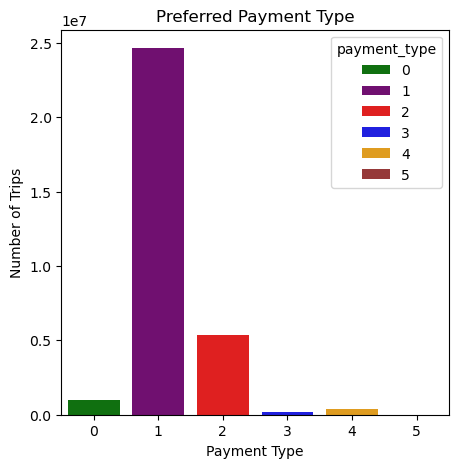

In [28]:

payment_types_data = clean_taxi_data.groupBy("payment_type").count().toPandas()

bar_colors = ['green', 'purple', 'red', 'blue', 'orange', 'brown']

plt.figure(figsize=(5, 5))
sns.barplot(x="payment_type", y="count", data=payment_types_data, palette=bar_colors, hue="payment_type")
plt.title("Preferred Payment Type")
plt.xlabel("Payment Type")
plt.ylabel("Number of Trips")
plt.show()

B) Distribution of trips through out the month.

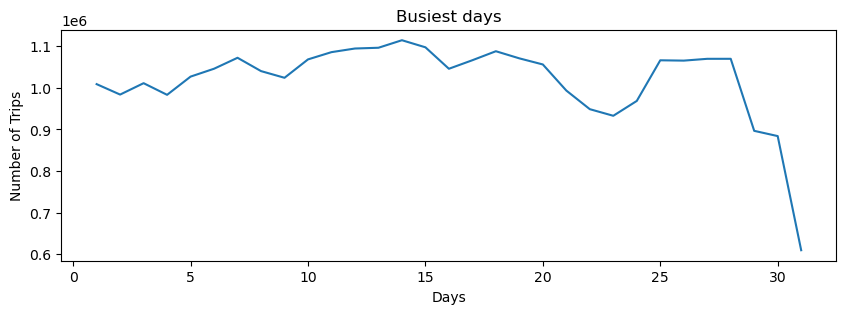

In [29]:

pickup_hour_data = clean_taxi_data.groupBy("pickup_day").agg(count("*").alias("no_of_trips")).toPandas()

plt.figure(figsize=(10, 3))
sns.lineplot(x="pickup_day", y="no_of_trips", data=pickup_hour_data)
plt.title("Busiest days")
plt.xlabel("Days")
plt.ylabel("Number of Trips")
plt.show()

C) Distribution of trips through out the year.

<Axes: xlabel='pickup_month', ylabel='no_of_trips'>

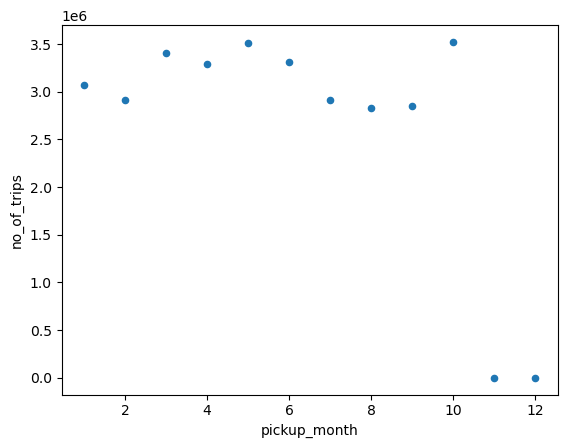

In [33]:
pickup_month_data = clean_taxi_data.groupBy("pickup_month").agg(count("*").alias("no_of_trips")).toPandas()

pickup_month_data.plot.scatter(x='pickup_month', y='no_of_trips')

D) Distribution of trips through the day

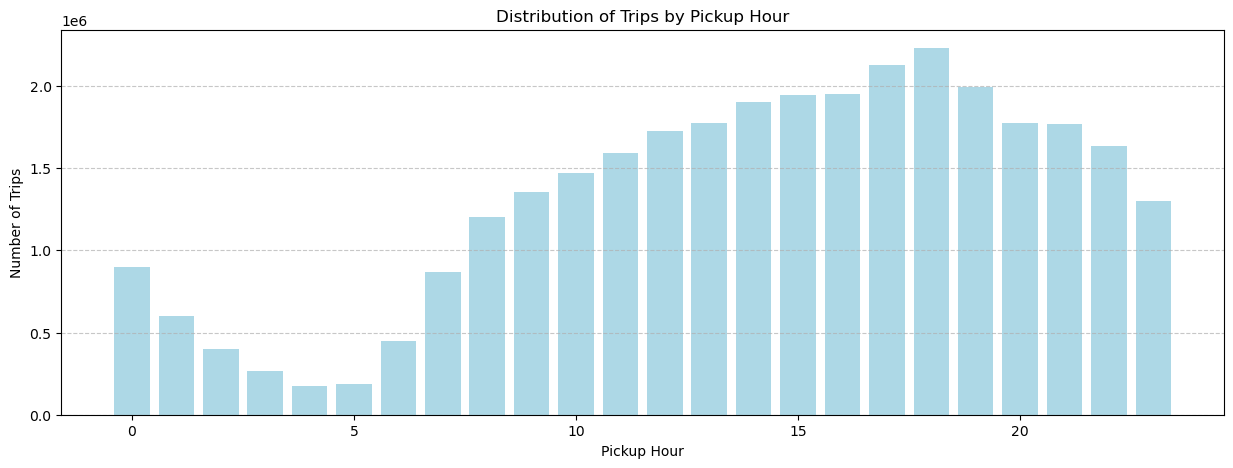

In [34]:

pickup_hour_data_pd = clean_taxi_data.groupBy("pickup_hour").agg(count("*").alias("no_of_trips")).toPandas()

plt.figure(figsize=(15, 5))
plt.bar(pickup_hour_data_pd['pickup_hour'], pickup_hour_data_pd['no_of_trips'], color='lightblue')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Pickup Hour')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

E) Distribution of Trips for every month

<Axes: ylabel='pickup_month'>

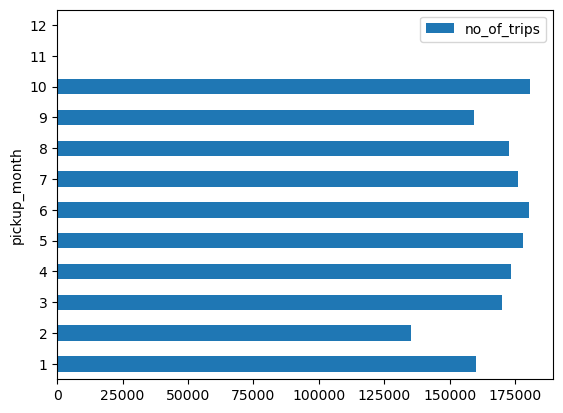

In [35]:
busiest_loc_per_month_pd = busiest_loc_per_month.toPandas()
busiest_loc_per_month_pd.plot.barh(x='pickup_month', y='no_of_trips') 


F) Distribution of trips troughout the Week

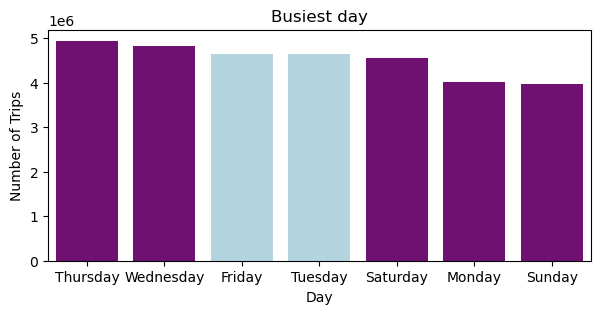

In [37]:
Busiest_day_pd = Busiest_day.toPandas()

bar_colors = ['purple', 'purple', 'lightblue', 'lightblue', 'purple', 'purple', 'purple']

plt.figure(figsize=(7, 3))
sns.barplot(x="week_day_full", y="no_of_trips", data=Busiest_day_pd, palette=bar_colors, hue="week_day_full")
plt.title("Busiest day")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.show()


G) Usage of payment types

<Axes: ylabel='payment_type'>

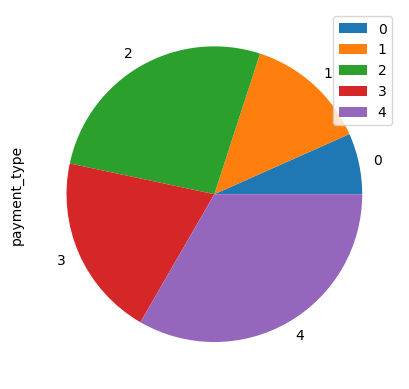

In [38]:

preferred_payment_type_pd = preferred_payment_type.toPandas()

preferred_payment_type_pd.plot.pie(y='payment_type')


H)Showcassing the Passenger count

<Axes: ylabel='passenger_count'>

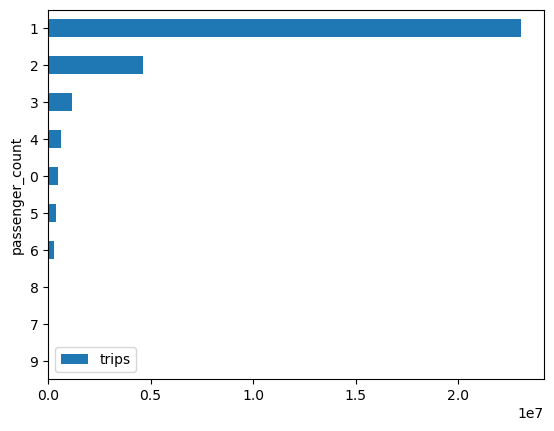

In [39]:
trip_passenger_count_pd = trip_passenger_count.toPandas()

trip_passenger_count_pd.plot.barh(x='passenger_count', y='trips') 


I) Perfformance of Vendors

<Axes: ylabel='VendorID'>

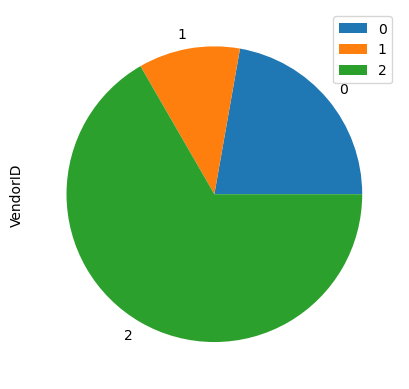

In [40]:
vendors_pd = vendors.toPandas()

vendors_pd.plot.pie(y='VendorID')

J) Rate Distribution

<Axes: >

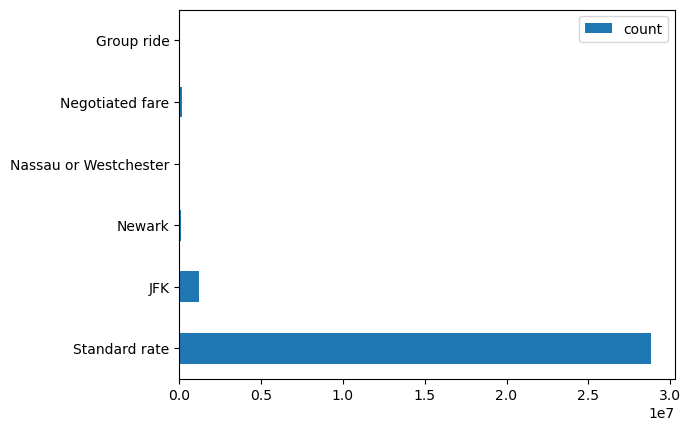

In [41]:
RatecodeID = [1, 2, 3, 4, 5, 6]
rcount = [28852288, 1234748, 105538, 63822, 171932, 52] 
index = ['Standard rate', 'JFK', 'Newark',
         'Nassau or Westchester', 'Negotiated fare', 'Group ride']

ratecode_count_pd = pd.DataFrame({'RatecodeID':RatecodeID,'count': rcount}, index=index)
ratecode_count_pd.plot.barh( y='count') 

K) Airport trip Distribution through out the year

<Axes: xlabel='pickup_month'>

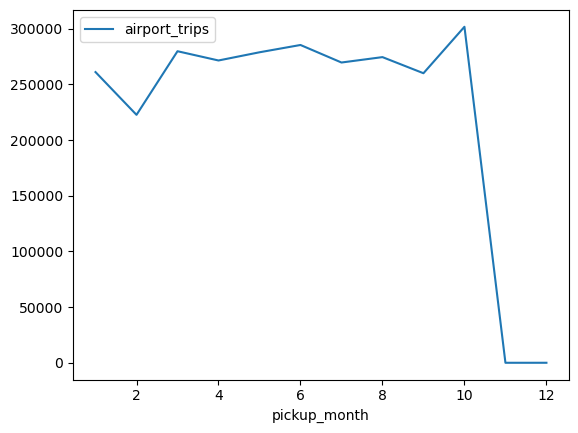

In [42]:
airport_trips_month_pd = airport_trips_month.toPandas()
airport_trips_month_pd.plot.line(x="pickup_month", y="airport_trips")
